# E-Divisive Analysis
This notebook aims to test out the different E-Divisive implementations we could be using in the Dashboard, starting with the one we already have and potentially using a combination of third-party libraries. The intent of the notebook is both to compare and contrast the different approaches, pros/cons of using each of these options.

NOTE: This requires that pandas, numpy, scipy, statsmodels, numba, and matplotlib are installed to execute. We are also using Python 3.7 to gain access to the latest versions of these libraries. To install these in your system, this should be sufficient:

```
pip3 install --user numpy scipy pandas statsmodels \
    numba matplotlib
```

In [1]:
import sys
_CATAPULT_PATH=os.path.join(os.path.abspath(''), '..', '..', '..')
_DASHBOARD_PATH=os.path.join(_CATAPULT_PATH, 'dashboard')

# Set up the environment so that we can import the modules in the
# Dashboard codebase.
sys.path.insert(0, _CATAPULT_PATH)
sys.path.insert(0, _DASHBOARD_PATH)

import dashboard
# Include all the paths needed for testing
for path in dashboard.PathsForTesting():
    sys.path.insert(0, path)

from dashboard.common import clustering_change_detector as ccd
import pandas as pd
import numpy as np
import statsmodels as sm
import numba as nb
import matplotlib.pyplot as plt

From this point on we can use `ccd` to refer to our clustering change detector implementation in the Dashboard. Here we can use all sorts of utilities that we can also analyse. The first one we'll use is the estimator implementation:


In [2]:
# Create a random dataset from some normal distributions.
measurements = np.concatenate(
        (np.random.normal(100, 5, 50),
        np.random.normal(20, 5, 50),
        np.random.normal(100, 5, 50)),
        axis=None)
commits = np.arange(1000,1150,dtype=np.int64)
frame = pd.DataFrame(measurements, columns=['measurement'], index=commits)
frame

,measurement
1000,105.626737
1001,99.566519
1002,95.326771
1003,103.067464
1004,100.389694
...,...
1145,105.881368
1146,103.028150
1147,100.868952
1148,96.767180


In [3]:
# We then create a column of estimates. First, we'll do it with
# the pure Python implementation, and time it.
def create_estimates(measurements):
    results = np.array(
        [ccd.Estimator(measurements, i) for i in
         range(len(measurements))])
    return results

estimates=create_estimates(measurements)
frame['estimates'] = estimates
frame['probability'] = estimates / np.nanmax(estimates)
%timeit create_estimates(measurements)

848 ms ± 6.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's now visualize the data, showing the probabilities along the range of values we've encountered. 

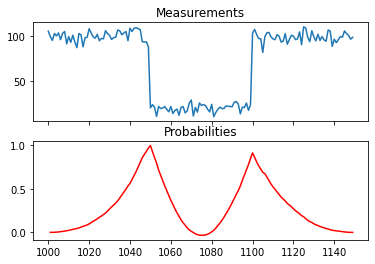

In [4]:
fig, axes = plt.subplots(2, 1, sharex=True)
frame['measurement'].plot.line(ax=axes[0], title='Measurements')
frame['probability'].plot.line(ax=axes[1], title='Probabilities',color='r')

As we can see in the charts above, we can now see how the estimator works for finding where change points could be based on how the particular point partitions the space. While that's interesting, we still need to check which/whether these high-probability change points partition the space nicely (or in a statistically significant way).

This is where the Mann-Whitney U-Test and Kolmogorov-Smirnov tests can help us with determining the likelihood that these are actually points that clearly partition the measurements. We'll use the `ChangePointEstimator` function to give us a most-likely index for the dataset we've provided.

In [5]:
# We need to convert the measurements into a Python list
# because the pure Python implementation can only work with
# those native objects.
inputs = list(measurements)
result = ccd.ClusterAndFindSplit(inputs)

# WARNING: Running this might take a while depending on how
# capable your machine is.
%timeit ccd.ClusterAndFindSplit(inputs)
print(result)

18.4 s ± 356 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
[46, 50, 100]


## Alternative A: Vectorized Implementation
The shortcoming for the above implementation, is that it's using a non-vectorized core performing permutation testing on sub-sets. In this section we're going to explore an alternative implementation which uses more facilities in `pandas` to help us generate the permutation space in a vectorized manner, as well as vectorize our computation of the estimator.

In [ ]:
# TODO(dberris): Implement the purely vectorized versions here.

## Alternative B: Using GPUs
While it's fine to be using just the SIMD instructions with `numba`, if we're dealing with a lot of data (in the order of tens of thousands of points) we might actually benefit from using GPUs.

In [ ]:
# TODO(dberris): Implement a GPU-accelerated versions here.